<a href="https://colab.research.google.com/github/the-astronot/intro_to_ai/blob/main/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Reqs

In [1]:
# Mass imports
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Quick timer
class Timer:
  def __init__(self):
    self.active = False
    self.duration = 0
    self.began = 0
  
  def start(self):
    if self.active == False:
      self.began = time.time()
      self.active = True
  
  def stop(self):
    if self.active == True:
      self.duration = time.time() - self.began
      self.active = False

  def read(self):
    if self.active == False:
      return self.duration
    return -1

In [3]:
debug = False
t = Timer()

# Homework 2

In Homework 2, I am re-implementing my Galaxy classifier with a Decision Tree Classifier rather than Logistic Regression. Once again, I'll be using [this stellar classification](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) dataset from Kaggle, and attempting to classify the included astral bodies as either galaxies or not galaxies.

In [4]:
df = pd.read_csv('star_classification.csv')
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


## Renaming Class to Obj_Type to Avoid Python Issues

In [5]:
df["obj_type"] = df["class"]
df.drop('class',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  redshift     100000 non-null  float64
 14  plate        100000 non-null  int64  
 15  MJD          100000 non-null  int64  
 16  fiber_ID     100000 non-null  int64  
 17  obj_type     100000 non-null  object 
dtypes: float64(10), int64(7),

## Validity Check

I showed that the dataset is comprised of ~60% galaxies during the last homework, but I'll do it again here for continuity's sake.

Text(0.5, 1.0, 'Types')

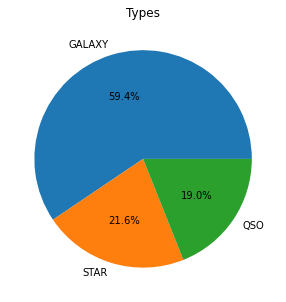

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df.obj_type.value_counts(), 
       labels=df.obj_type.value_counts().index,
       autopct='%1.1f%%')
ax.set_title('Types')

# Data Processing

## IDS
The columns {obj_ID, run_ID, rerun_ID, field_ID, spec_obj_ID} are all for use by those making the observations and are not properties of the objects themselves.

## Equipment Data

The columns {cam_col, plate, fiber_ID} are all recordings of how the data was captured, but are similarly not inherent to the object.

In [7]:
df.drop(["obj_ID","run_ID","rerun_ID","field_ID","spec_obj_ID","cam_col","plate","fiber_ID"],axis=1,inplace=True)
df.describe()

,alpha,delta,u,g,r,i,z,redshift,MJD
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661,55588.647500
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707,1808.484233
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971,51608.000000
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517,54234.000000
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173,55868.500000
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154,56777.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245,58932.000000


## N/A Check

In [8]:
# Dropping the min vals from the u,g,z columns
df = df[df.u > -9999.0]
df.describe()

,alpha,delta,u,g,r,i,z,redshift,MJD
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,0.576667,55588.653687
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,0.730709,1808.492217
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971,51608.000000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,0.054522,54234.000000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,0.424176,55869.000000
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,0.704172,56777.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245,58932.000000


In [9]:
df.isna()

,alpha,delta,u,g,r,i,z,redshift,MJD,obj_type
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,False,False,False,False,False
99998,False,False,False,False,False,False,False,False,False,False


## isGalaxy
I had to make a new boolean column for the truth data on whether or not a data point is a galaxy or not.

In [10]:
df['isGalaxy'] = 0
df.loc[df['obj_type'] == "GALAXY", 'isGalaxy'] = 1
df.drop('obj_type',axis=1,inplace=True)
df.describe()

,alpha,delta,u,g,r,i,z,redshift,MJD,isGalaxy
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,0.576667,55588.653687,0.594456
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,0.730709,1808.492217,0.490999
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971,51608.000000,0.000000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,0.054522,54234.000000,0.000000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,0.424176,55869.000000,1.000000
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,0.704172,56777.000000,1.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245,58932.000000,1.000000


# Correlation Check

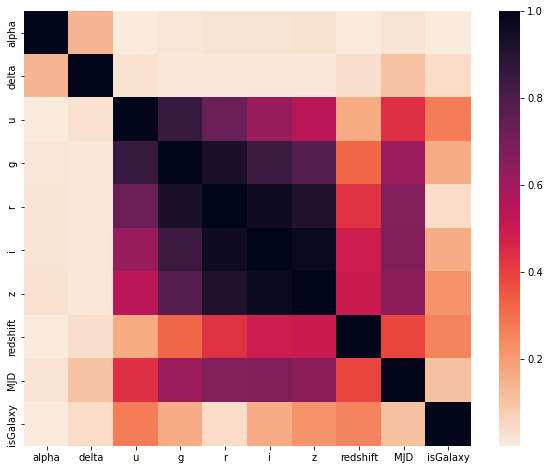

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [12]:
df.corr()['isGalaxy'].sort_values(ascending=False)

isGalaxy    1.000000
u           0.272524
g           0.163133
alpha       0.004091
r          -0.038007
delta      -0.038312
MJD        -0.110589
i          -0.160388
z          -0.219269
redshift   -0.256938
Name: isGalaxy, dtype: float64

It's looking like the alpha and delta (Right Ascension and Declination) have no meaningful effect whatsoever on anything, least of all my target, so I suppose I might as well remove them from the inputs as well.

After some testing, it appears that I still have too many unnecessary variables, and ended up dropping r and MJD as well.

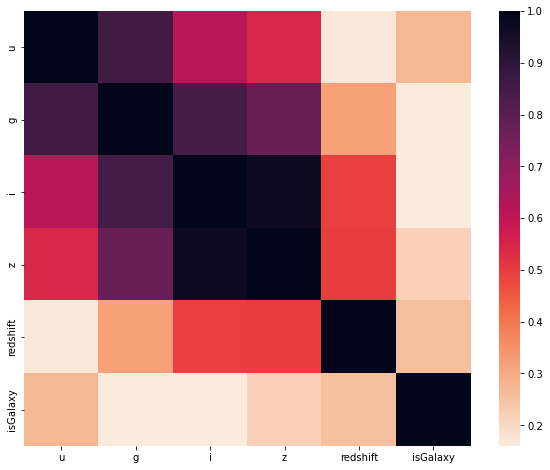

In [13]:
df.drop(["alpha","delta","r","MJD"],axis=1,inplace=True)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

# Partitioning the Data

In [14]:
# independent variables
x = df.drop(['isGalaxy'],axis=1)
# dependent/target
y = df.isGalaxy

# Separate Training, Validation and Test Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

# Feature Scaling

I scaled the features using the maximum as the normalizer, as that seemed to make the most sense for the data I was working with.

In [15]:
transformer = Normalizer(norm='max').fit(x)
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)
x_valid = transformer.transform(x_valid)

# Trees

For this assignment, I am targeting a high accuracy rating. Since my dataset is fairly evenly distributed, and both positive and negative predictions are of equal importance/value, I find my desired outcome best expressed by the accuracy metric rather than precision or recall.

I've set the random_state to 42, so as to better relate the effects of my modifications.

The Accuracy of the Model with Cross Validation is: 95.210%
The Accuracy of the Model on the Test Set is : 95.575%
TIME_TAKEN: 2.076s


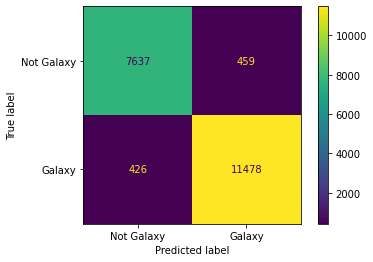

In [16]:
t.start()
## Training
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(dtc.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(dtc,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])
t.stop()
print("TIME_TAKEN: {:.3f}s".format(t.duration))

Experimenting with random splits instead of best splits yields roughly the same outcome. The change in accuracy of the cross-validation appears to be approximately a 1% decrease, but I don't see that as being definitive enough to pass any judgement on it.

The Accuracy of the Model with Cross Validation is: 94.150%
The Accuracy of the Model on the Test Set is : 94.860%


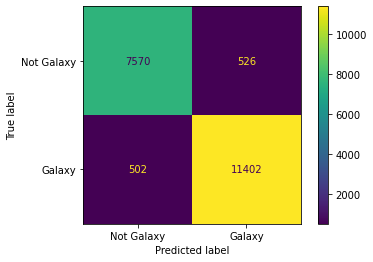

In [17]:
## Training
dtc = DecisionTreeClassifier(random_state=42,splitter="random")
dtc.fit(x_train,y_train)

## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(dtc.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(dtc,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])

I also tried changing up the criterion to use entropy rather than the gini index, which likewise yields very similar results.

The Accuracy of the Model with Cross Validation is: 95.460%
The Accuracy of the Model on the Test Set is : 95.605%


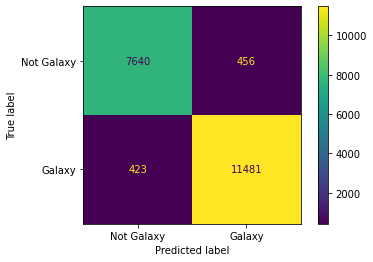

In [18]:
## Training
dtc = DecisionTreeClassifier(random_state=42,criterion="entropy")
dtc.fit(x_train,y_train)

## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(dtc.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(dtc,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])

## Testing Max_Depth

I was interested in seeing how much of a difference varying the max_depth of the tree would yield.

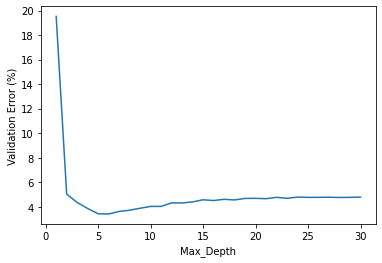

In [19]:
err_valid = []
m_depth = [x for x in range(1,31)]
for i in range(1,31):
  ## Training
  dtc = DecisionTreeClassifier(random_state=42,max_depth=i)
  dtc.fit(x_train,y_train)
  ## Validation
  valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
  err_valid.append(100-valid_score.mean()*100)

plt.plot(m_depth,err_valid)
plt.xlabel("Max_Depth")
plt.ylabel("Validation Error (%)")
plt.show()

I'm seeing a minimization of error in cross validation at a Max_Depth of 5-6. It would appear to me that after that point, the model begins overfitting to the training data. With this in mind, I tested the model trained mwith a max_depth of 5.

The Accuracy of the Model with Cross Validation is: 96.570%
The Accuracy of the Model on the Test Set is : 96.505%


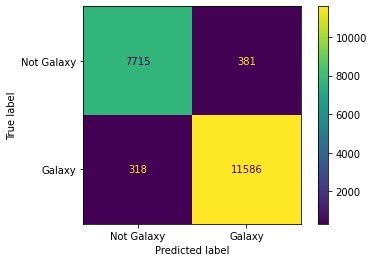

In [20]:
## Training
dtc = DecisionTreeClassifier(random_state=42,max_depth=5)
dtc.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(dtc.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(dtc,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])

While not a large change, setting a max_depth of 5 for the model seems to have yielded a decrease in the error of the cross validation score a little over 1%.

## Testing Min_Samples_Split

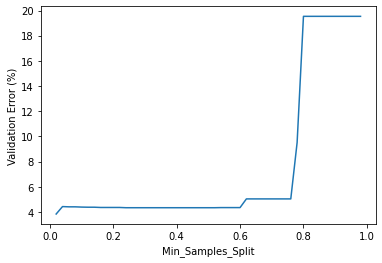

In [21]:
rng = 50
err_valid = []
m_depth = [x/float(rng) for x in range(1,rng)]
for i in range(1,rng):
  ## Training
  dtc = DecisionTreeClassifier(random_state=42,min_samples_split=i/float(rng))
  dtc.fit(x_train,y_train)
  ## Validation
  valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
  err_valid.append(100-valid_score.mean()*100)

plt.plot(m_depth,err_valid)
plt.xlabel("Min_Samples_Split")
plt.ylabel("Validation Error (%)")
plt.show()

I'm not seeing a minimization that I can make here. Maybe I should be trying even smaller values?

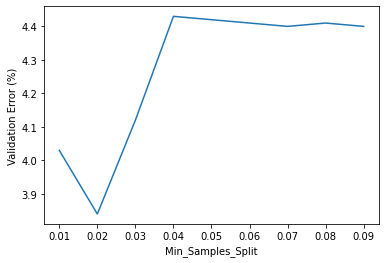

In [22]:
rng = 10
err_valid = []
m_depth = [x/float(rng*10) for x in range(1,rng)]
for i in range(1,rng):
  ## Training
  dtc = DecisionTreeClassifier(random_state=42,min_samples_split=i/float(rng*10))
  dtc.fit(x_train,y_train)
  ## Validation
  valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
  err_valid.append(100-valid_score.mean()*100)

plt.plot(m_depth,err_valid)
plt.xlabel("Min_Samples_Split")
plt.ylabel("Validation Error (%)")
plt.show()

Now we're getting somewhere...

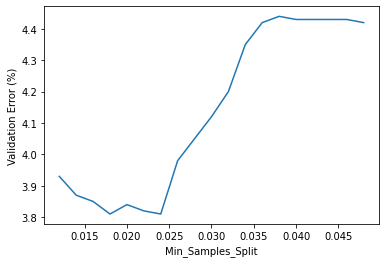

In [23]:
rng = 20
err_valid = []
m_depth = [(x*.002)+0.010 for x in range(1,rng)]
for i in range(1,rng):
  ## Training
  dtc = DecisionTreeClassifier(random_state=42,min_samples_split=(i*.002)+0.010)
  dtc.fit(x_train,y_train)
  ## Validation
  valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
  err_valid.append(100-valid_score.mean()*100)

plt.plot(m_depth,err_valid)
plt.xlabel("Min_Samples_Split")
plt.ylabel("Validation Error (%)")
plt.show()

There we go. It's looking like we begin to overfit the model after a min_samples_split value of approx 0.02.

The Accuracy of the Model with Cross Validation is: 96.160%
The Accuracy of the Model on the Test Set is : 96.360%


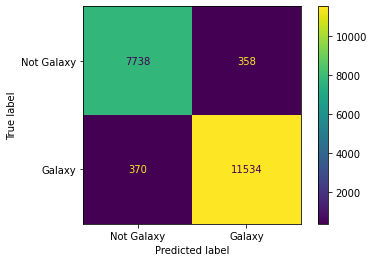

In [24]:
## Training
dtc = DecisionTreeClassifier(random_state=42,min_samples_split=0.02)
dtc.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(dtc.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(dtc,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])

This also shows some minor improvement over the original classifier I presented, but again, the gains made in the accuracy of cross validation is very small.

## Testing Max_Leaf_Nodes

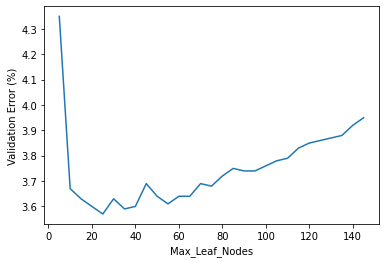

In [25]:
rng = 30
err_valid = []
m_depth = [x*5 for x in range(1,rng)]
for i in range(1,rng):
  ## Training
  dtc = DecisionTreeClassifier(random_state=42,max_leaf_nodes=i*5)
  dtc.fit(x_train,y_train)
  ## Validation
  valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
  err_valid.append(100-valid_score.mean()*100)

plt.plot(m_depth,err_valid)
plt.xlabel("Max_Leaf_Nodes")
plt.ylabel("Validation Error (%)")
plt.show()

Overfitting after approx 25 max_leaf_nodes...

The Accuracy of the Model with Cross Validation is: 96.430%
The Accuracy of the Model on the Test Set is : 96.560%


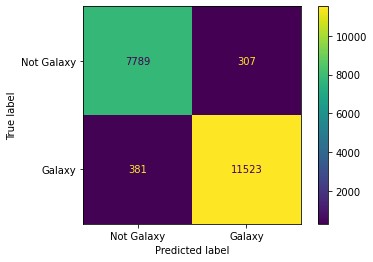

In [26]:
## Training
dtc = DecisionTreeClassifier(random_state=42,max_leaf_nodes=25)
dtc.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(dtc.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(dtc,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])

## Bagging Algorithm


The Accuracy of the Model with Cross Validation is: 96.540%
The Accuracy of the Model on the Test Set is : 96.820%
TIME_TAKEN: 7.545s


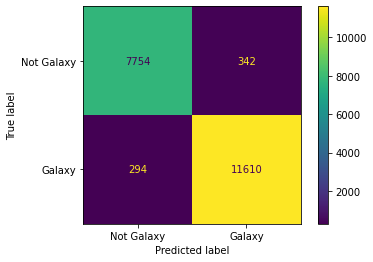

In [27]:
t.start()
## Training
bme = BaggingClassifier(random_state=42)
bme.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(bme, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(bme.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(bme,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])
t.stop()
print("TIME_TAKEN: {:.3f}s".format(t.duration))

Right off the bat, without any modifications on my part, the bagging model appears to have performed better on both the cross validation and the test data than any of my above tests modifying values. This makes sense to me, as the bagging classifier is in essence creating many trees and finding the best versions to create its final model from. It likely found better optimiszations than I was able to in my investigations and likely combine those optimizations to yield an even better model.

## Boosting Algorithm

The Accuracy of the Model with Cross Validation is: 95.860%
The Accuracy of the Model on the Test Set is : 95.500%
TIME_TAKEN: 8.234s


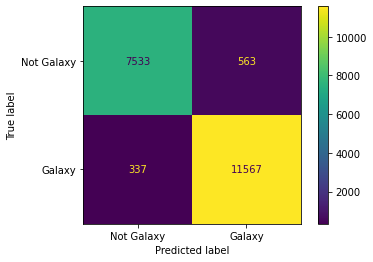

In [28]:
t.start()
## Training
bme = AdaBoostClassifier(random_state=42)
bme.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(bme, x_valid, y_valid, cv=10, scoring="accuracy")
print("The Accuracy of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
## Testing 
acc = accuracy_score(bme.predict(x_test),y_test)
print("The Accuracy of the Model on the Test Set is : {:.3f}%".format(acc*100))
CMD.from_estimator(bme,x_test,y_test,display_labels=["Not Galaxy","Galaxy"])
t.stop()
print("TIME_TAKEN: {:.3f}s".format(t.duration))

The Ada Boosting algorithm ended up producing a model with very similar output to my original default tree classifier. I have to imagine that this is do to my model already doing a pretty good job? As far as I understand, boosting algorithms are designed to take weaker models and train them to be better, combining together to create a greater final model. My original model however was already achieving a >95% accuracy rating. I wonder if the original model had already essentially hit the limit of what it was capable of and therefore Ada Boost wasn't able to improve on that any further?

# Comparisons

Using my accuracy metric identified above when introducing the trees, it would seem that the bagging model produced the most desirable results, followed by the boosting and original models. To reiterate, I have chosen accuracy as my metric of choice due to:

1. The division of my data into classes being fairly even (60-40)
2. There being an equivalent weight/value placed on both positive and negative predictions (neither is more dire/requires more attention, like in predicting illnesses where false positives is usually preferable to false negatives)

With these givens as the foundation of my model, I found accuracy to be a more desirable metric than precision or recall.

If however, I was to change my mind and require a different metric for evaluating my model, the choice of metrics would certainly change the tierlist of best models for the job.

For example: precision only cares about positive predictions. As can be seen, the vast majority of false predictions seen in the boosting output are false positives, which would greatly decrease the observed precision of the model. The other models tend to have a more balanced division of false predictions between positives and negatives.

## Proof

In [29]:
# ADA
## Training
bme = AdaBoostClassifier(random_state=42)
bme.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(bme, x_valid, y_valid, cv=10, scoring="precision")
print("The Precision of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))
# Standard
## Training
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(x_train,y_train)
## Validation
valid_score = cross_val_score(dtc, x_valid, y_valid, cv=10, scoring="precision")
print("The Precision of the Model with Cross Validation is: {:.3f}%".format(valid_score.mean()*100))

The Precision of the Model with Cross Validation is: 95.684%
The Precision of the Model with Cross Validation is: 96.028%


If you were to re-examine the outputs, you would see that the precision of the AdaBoost Model is 0.2% lower than its accuracy, while the precision of the Default Model is 0.8% higher than its own accuracy. This is by no means a large difference, as both models still perform a reasonably good job at identifying galaxies, but the difference between the metrics is still present, quanitifable, and matches expectations.